# Attention-based Transformer

A good physics application is the analysis of waveforms from an experiment.

We will look at waveforms from a Cherenkov water detector like the Pierre Auger Observatory.

These waveforms contain the detector response to three different classes of events:
- cosmic ray air shower
- single muon
- electronic noise

The Attention-Based Transformer is a good choice here because self-attention can learn to focus on the relevant temporal features (rise time, peak structure, decay tail) while ignoring noisy regions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math

torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


## Generating synthetic dataset

The problem is that the raw waveforms are not publicly available from the experiments, so we will have to generate some data using some basic assumptions about the waveforms.

Cosmic ray observatories like the Pierre Auger Observatory use water Cherenkov detectors (WCDs) to detect extensive air showers. When secondary particles from a cosmic ray shower pass through a tank of purified water, they emit Cherenkov light, which is recorded by photomultiplier tubes (PMTs) as a time-resolved voltage waveform sampled at 40 MHz (25 ns per bin), coincidentally the same rate as the LHC.

In [2]:
# -- Waveform parameters (inspired by Pierre Auger / LAGO WCDs) --
WAVEFORM_LENGTH = 256     # time bins (~6.4 us at 40 MHz)
SAMPLING_DT     = 25e-9   # 25 ns per bin

# -- Classes --
NUM_CLASSES = 3
CLASS_NAMES = ["Cosmic Ray Signal", "Single Muon Background", "Electronic Noise"]
CLASS_SHORT = ["Signal", "Muon BG", "Noise"]

# -- Model --
D_MODEL  = 64
N_HEADS  = 4
N_LAYERS = 3
D_FF     = 128
DROPOUT  = 0.1

# -- Training --
BATCH_SIZE    = 128
NUM_EPOCHS    = 25
LEARNING_RATE = 5e-4
NUM_TRAIN     = 12_000
NUM_VAL       = 3_000

A WCD waveform is a 1D time series with the following possibilities:
- sharp rise characteristic of Cherenkov signals
- long muonic tail (real showers)
- temporal correlations across the entire trace simultaneously


In [3]:
def generate_waveform(cls, length=WAVEFORM_LENGTH):
    """Generate a single synthetic WCD waveform.

    Physics-inspired model based on water Cherenkov detector responses
    from Pierre Auger and LAGO observatories.

    Returns: waveform (length,) in units of VEM (Vertical Equivalent Muon)
    """
    t = np.arange(length, dtype=np.float32)
    baseline_noise = np.random.normal(0, 0.03, length).astype(np.float32)

    if cls == 0:  # Cosmic ray shower signal
        # Signal arrives at a random time in the trace
        t0 = np.random.uniform(40, 80)
        amplitude = np.random.uniform(1.0, 15.0)  # VEM units

        # Electromagnetic component: fast rise, ~exponential decay
        rise_time = np.random.uniform(1.5, 3.0)   # bins
        em_decay  = np.random.uniform(8.0, 20.0)   # bins
        em = np.where(t > t0,
                      amplitude * (1 - np.exp(-(t - t0)/rise_time)) * np.exp(-(t - t0)/em_decay),
                      0.0)

        # Muonic component: delayed, slower rise, long tail
        mu_fraction = np.random.uniform(0.2, 0.6)
        mu_delay    = np.random.uniform(2.0, 8.0)
        mu_decay    = np.random.uniform(40.0, 100.0)
        mu_rise     = np.random.uniform(3.0, 6.0)
        t_mu = t - t0 - mu_delay
        mu = np.where(t_mu > 0,
                      amplitude * mu_fraction * (1 - np.exp(-t_mu/mu_rise)) * np.exp(-t_mu/mu_decay),
                      0.0)

        # Photoelectron fluctuations (Poisson-like)
        signal = em + mu
        pe_noise = np.random.normal(0, 0.05 * np.sqrt(np.abs(signal) + 0.01))
        waveform = signal + pe_noise + baseline_noise

    elif cls == 1:  # Single muon background
        t0 = np.random.uniform(40, 180)
        amplitude = np.random.uniform(0.8, 1.5)  # ~1 VEM by definition
        width = np.random.uniform(3.0, 8.0)

        # Nearly symmetric pulse (slight asymmetry from light propagation)
        rise = np.random.uniform(1.5, 3.0)
        fall = np.random.uniform(3.0, 8.0)
        pulse = np.where(t < t0,
                         amplitude * np.exp(-0.5 * ((t - t0)/rise)**2),
                         amplitude * np.exp(-0.5 * ((t - t0)/fall)**2))

        pe_noise = np.random.normal(0, 0.03 * np.sqrt(np.abs(pulse) + 0.01))
        waveform = pulse + pe_noise + baseline_noise

    else:  # Electronic noise
        waveform = baseline_noise.copy()

        # Occasional random narrow spikes (RF interference / after-pulses)
        n_spikes = np.random.poisson(2)
        for _ in range(n_spikes):
            spike_t = np.random.randint(10, length - 10)
            spike_amp = np.random.uniform(0.1, 0.5)
            spike_w = np.random.uniform(1.0, 3.0)
            waveform += spike_amp * np.exp(-0.5 * ((t - spike_t)/spike_w)**2)

        # Low-frequency drift
        drift_freq = np.random.uniform(0.5, 3.0)
        drift_amp  = np.random.uniform(0.01, 0.05)
        waveform  += drift_amp * np.sin(2 * np.pi * drift_freq * t / length)

    return waveform.astype(np.float32)


class CosmicRayWaveformDataset(Dataset):
    def __init__(self, num_samples):
        self.waveforms = []
        self.labels = []
        for _ in range(num_samples):
            label = np.random.randint(0, NUM_CLASSES)
            self.waveforms.append(generate_waveform(label))
            self.labels.append(label)
        self.waveforms = np.array(self.waveforms)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.waveforms[idx]),
            torch.tensor(self.labels[idx]),
        )

### Visualizing the synthetic data waveforms

Plot 3 examples for each class. Check to see whether there are any differences and if the scale and range of the waveforms look consistent.

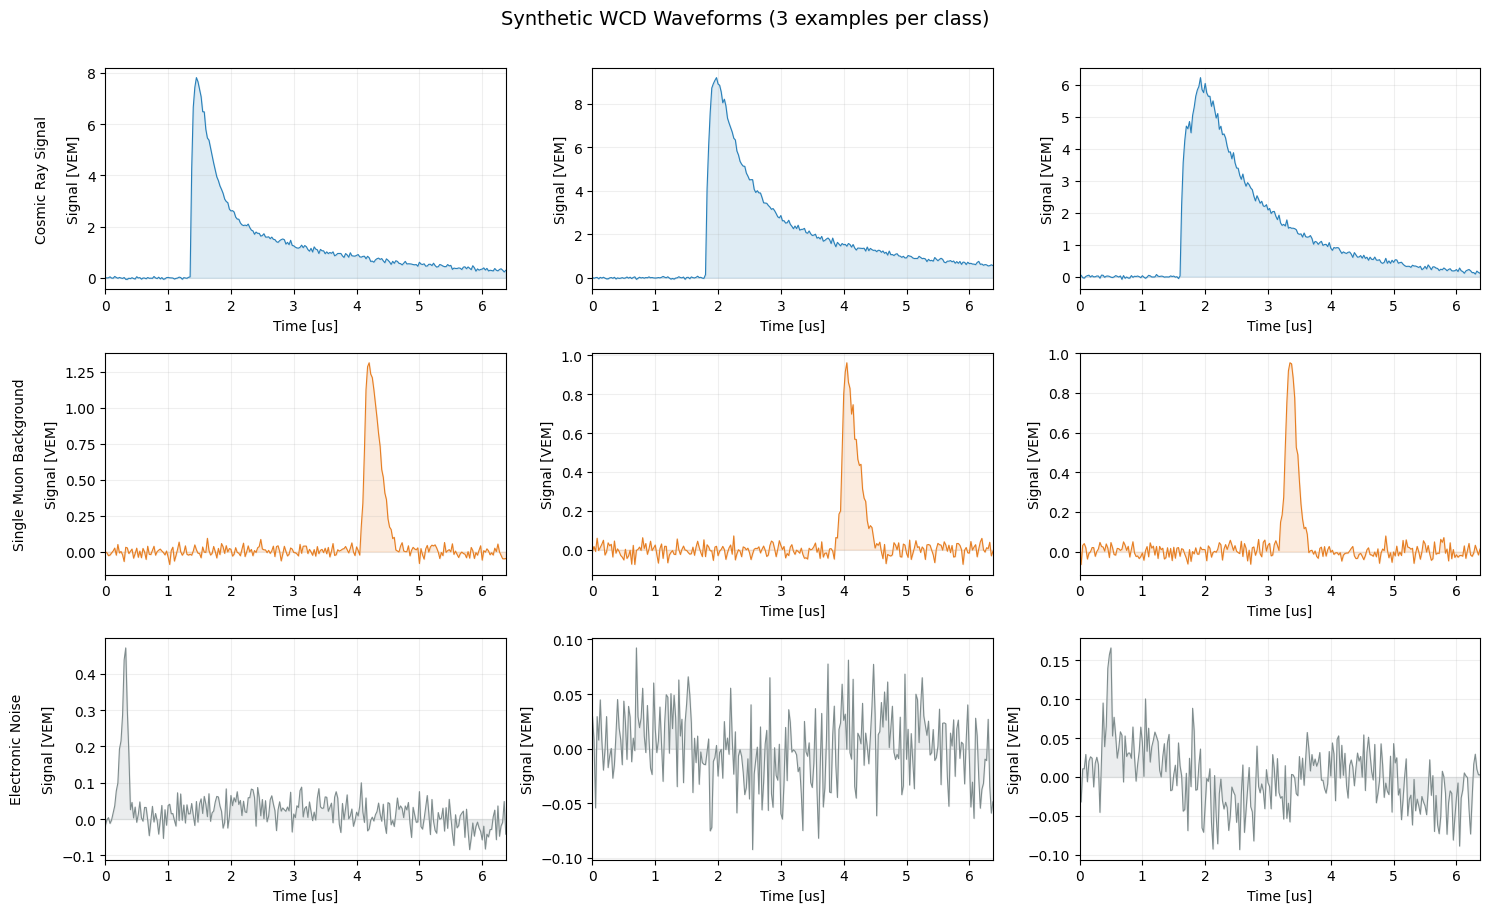

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(15, 9))
time_us = np.arange(WAVEFORM_LENGTH) * SAMPLING_DT * 1e6  # microseconds

for cls in range(NUM_CLASSES):
    for j in range(3):
        wf = generate_waveform(cls)
        ax = axes[cls, j]
        ax.plot(time_us, wf, linewidth=0.8, color=["#2980b9", "#e67e22", "#7f8c8d"][cls])
        ax.fill_between(time_us, 0, wf, alpha=0.15,
                         color=["#2980b9", "#e67e22", "#7f8c8d"][cls])
        ax.set_xlabel("Time [us]")
        ax.set_ylabel("Signal [VEM]")
        if j == 0:
            ax.set_ylabel(f"{CLASS_NAMES[cls]}\n\nSignal [VEM]")
        ax.set_xlim(0, time_us[-1])
        ax.grid(alpha=0.2)

plt.suptitle("Synthetic WCD Waveforms (3 examples per class)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## ML architecture

Classifying waveforms as signal (real cosmic ray shower) vs. background is traditionally done with hand-crafted cuts on pulse height, rise time, and integrated charge. We will train a Transformer to do it directly from the raw waveform.

We treat the waveform as a sequence of *patches* (groups of consecutive time bins), similar to how Vision Transformers (ViT) treat image patches. Each patch becomes one token for the Transformer.

**Architecture:**
1. Patch tokenization: split the waveform into non-overlapping patches (tokens)
2. Positional encoding: sinusoidal ordering (time ordering matters for waveforms, unlike jets!)
3. PyTorch `nn.TransformerEncoder`: self-attention over tokens
4. Classification (CLS) token: a learnable token prepended to the sequence; its output is used for classification
5. Classification network: MLP

The positional encoding is an essential component here (unlike particle jet classifier) because the time sequence of the waveform matters.

In [7]:
class SinusoidalPositionalEncoding(nn.Module):
    """Sinusoidal positional encoding (Vaswani et al., 2017).

    Injects information about the ordering of patches in the waveform.
    Uses sine/cosine functions at different frequencies -- a Fourier-like
    basis for encoding position.
    """
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [5]:
class WaveformTransformerClassifier(nn.Module):
    """
    Transformer-based classifier for cosmic ray waveforms.

    Architecture:
      - Patch tokens (waveform -> sequence of patch tokens)
      - Learnable classification token prepended to the sequence
      - Sinusoidal positional encoding
      - nn.TransformerEncoder (PyTorch built-in)
      - Classification head on [CLS] output
    """

    def __init__(self, waveform_length=WAVEFORM_LENGTH, patch_size=8,
                 d_model=D_MODEL, n_heads=N_HEADS, n_layers=N_LAYERS,
                 d_ff=D_FF, n_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches  = waveform_length // patch_size  # 256/8 = 32 patches

        # Patch embedding: project each patch (patch_size values) -> d_model
        self.patch_embed = nn.Sequential(
            nn.Linear(patch_size, d_model),
            nn.LayerNorm(d_model),
        )

        # Learnable [CLS] token -- aggregates information for classification
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        # Positional encoding (sinusoidal -- order matters for waveforms!)
        self.pos_enc = SinusoidalPositionalEncoding(d_model, max_len=self.n_patches + 1)
        self.dropout = nn.Dropout(dropout)

        # Transformer encoder (PyTorch built-in)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, activation="gelu", batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Classification head (operates on [CLS] token output)
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, n_classes),
        )

    def forward(self, waveform):
        """waveform: (B, waveform_length) -- raw 1D signal"""
        B = waveform.size(0)

        # Split into patches: (B, n_patches, patch_size)
        x = waveform.view(B, self.n_patches, self.patch_size)

        # Embed patches: (B, n_patches, d_model)
        x = self.patch_embed(x)

        # Prepend classification [CLS] token: (B, n_patches+1, d_model)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional encoding
        x = self.dropout(self.pos_enc(x))

        # Transformer encoder
        x = self.transformer(x)              # (B, n_patches+1, d_model)

        # Classify using [CLS] token output (position 0)
        cls_output = x[:, 0]                 # (B, d_model)
        return self.classifier(cls_output)   # (B, n_classes)

Here is the strategy for the architecture.

First, the waveform becomes a sequence of tokens. The raw waveform is 256 time bins long. We chop it into 32 non-overlapping patches of 8 bins each, and each patch gets projected into a 64-dimensional vector. We also prepend a learnable classification (CLS) token, giving us 33 tokens total. So the Transformer sees a sequence of 33 vectors, each of dimension 64.

Then self-attention kicks in. Every token asks: "which other tokens in this sequence are most relevant to me?" Practically, each token's 64-dimensional vector gets projected into three roles via learned weight matrices:

- Query — "I'm a patch covering time bins 40–48 (the rising edge). What else should I pay attention to?"
- Key — "I'm a patch covering time bins 80–88 (the muonic tail). Here's what I contain."
- Value — "If you decide I'm relevant, here's the information I'll contribute."

Finally, the dot product between a Query and every Key gives similarity scores. After scaling by 1/dk1/\sqrt{d_k}
1/dk​​ and applying softmax, these become attention weights, which are just a probability distribution over all 33 tokens. The output for each token is then a weighted sum of all the Value vectors.

The classifier considers all 32 patches simultaneously and decides which parts of the waveform are informative. For a cosmic ray signal, it might put high attention weight on the patch containing the sharp rise and the patch containing the muonic tail far away in time. An RNN would have to sequentially carry information from the rising edge through dozens of irrelevant time steps to compare it with the tail, but the Transformer here connects them directly in one step.

With 4 heads, the classifier consideration happens four times in parallel with different learned projections. One head might specialize in detecting the rise time, another might focus on the tail-to-peak ratio, and another might learn to recognize noise patterns. Their outputs get concatenated and projected back to 64 dimensions.

That's one Transformer block. We stack 3 of them here, so the representation gets progressively refined.
By the final layer, the classifier token has aggregated exactly the information it needs from across the entire waveform to make a classification decision.

In [8]:
model = WaveformTransformerClassifier().to(DEVICE)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {n_params:,}")
print(f"Patches per waveform: {model.n_patches} (patch size = {model.patch_size})\n")
print(model)

Trainable parameters: 110,019
Patches per waveform: 32 (patch size = 8)

WaveformTransformerClassifier(
  (patch_embed): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (pos_enc): SinusoidalPositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): 

## Training the transformer network

We use the `DataLoaders` and usual training loops for the ML algorithm, with the standard `CrossEntropyLoss` and a new scheduler: `CosineAnnealingLR`.

In [12]:
train_ds = CosmicRayWaveformDataset(NUM_TRAIN)
val_ds   = CosmicRayWaveformDataset(NUM_VAL)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

print(f"Train: {len(train_ds):,}  |  Val: {len(val_ds):,}")

Train: 12,000  |  Val: 3,000


In [13]:
def train_one_epoch(model, loader, opt, crit):
    model.train()
    loss_sum, correct, total = 0., 0, 0
    for wf, labels in loader:
        wf, labels = wf.to(DEVICE), labels.to(DEVICE)
        opt.zero_grad()
        logits = model(wf)
        loss = crit(logits, labels)
        loss.backward()
        opt.step()
        loss_sum += loss.item() * len(labels)
        correct  += (logits.argmax(1) == labels).sum().item()
        total    += len(labels)
    return loss_sum / total, correct / total


@torch.no_grad()
def evaluate(model, loader, crit):
    model.eval()
    loss_sum, correct, total = 0., 0, 0
    for wf, labels in loader:
        wf, labels = wf.to(DEVICE), labels.to(DEVICE)
        logits = model(wf)
        loss = crit(logits, labels)
        loss_sum += loss.item() * len(labels)
        correct  += (logits.argmax(1) == labels).sum().item()
        total    += len(labels)
    return loss_sum / total, correct / total

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, NUM_EPOCHS + 1):
    tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
    vl, va = evaluate(model, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tl)
    history["val_loss"].append(vl)
    history["train_acc"].append(ta)
    history["val_acc"].append(va)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:>3d}  |  train loss {tl:.4f}  acc {ta:.1%}"
              f"  |  val loss {vl:.4f}  acc {va:.1%}")

print(f"\nBest val accuracy: {max(history['val_acc']):.1%}")

Epoch   1  |  train loss 0.2188  acc 93.2%  |  val loss 0.0491  acc 98.8%
Epoch   5  |  train loss 0.0092  acc 99.8%  |  val loss 0.0143  acc 99.6%
Epoch  10  |  train loss 0.0053  acc 99.8%  |  val loss 0.0051  acc 99.9%
Epoch  15  |  train loss 0.0034  acc 99.9%  |  val loss 0.0047  acc 99.8%
Epoch  20  |  train loss 0.0020  acc 99.9%  |  val loss 0.0055  acc 99.8%
Epoch  25  |  train loss 0.0015  acc 100.0%  |  val loss 0.0037  acc 99.9%

Best val accuracy: 99.9%


### Monitoring training loss and accuracy

The network learns very very fast, with nearly 100% accuracy.
We could actually reduce the number of epochs.

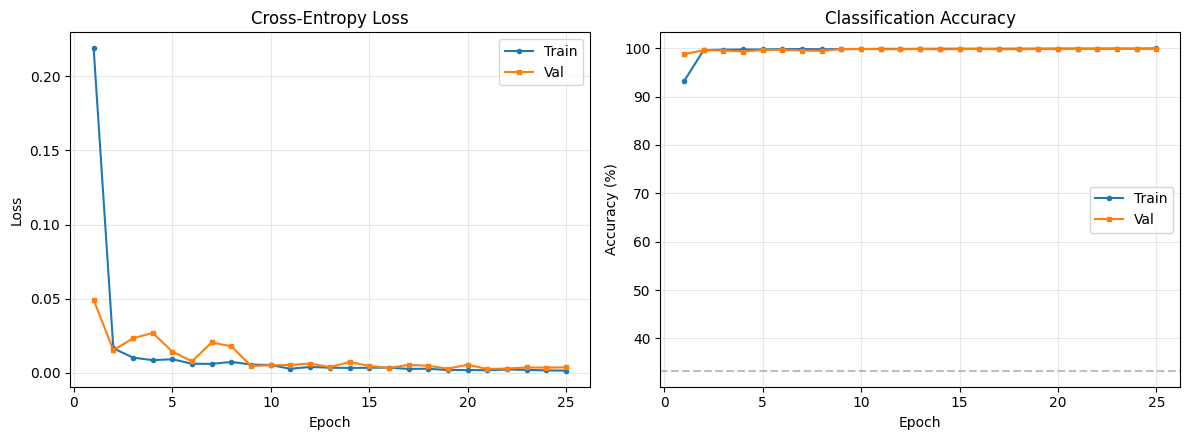

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
epochs = range(1, NUM_EPOCHS + 1)

ax1.plot(epochs, history["train_loss"], "o-", label="Train", markersize=3)
ax1.plot(epochs, history["val_loss"],   "s-", label="Val",   markersize=3)
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
ax1.set_title("Cross-Entropy Loss"); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(epochs, [a*100 for a in history["train_acc"]], "o-", label="Train", markersize=3)
ax2.plot(epochs, [a*100 for a in history["val_acc"]],   "s-", label="Val",   markersize=3)
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Classification Accuracy"); ax2.legend(); ax2.grid(alpha=0.3)
ax2.axhline(100/NUM_CLASSES, ls="--", c="gray", alpha=0.5)

plt.tight_layout()
plt.show()

### What is the transformer paying attention to?

We can extract attention weights from the Transformer to see which parts of the waveform the model focuses on. For cosmic ray signals, we'd expect the model to attend strongly to:
- the rising edge (where the shower front arrives)
- the muonic tail (which distinguishes showers from single muons)




In [16]:
def extract_attention(model, waveform):
    """Extract attention weights from all layers using hooks."""
    attn_list = []
    hooks = []

    for layer in model.transformer.layers:
        def hook_fn(module, args, output, storage=attn_list):
            if isinstance(output, tuple) and len(output) == 2:
                storage.append(output[1].detach())

        original_forward = layer.self_attn.forward
        def patched_forward(orig=original_forward):
            def wrapper(*a, **kw):
                kw['need_weights'] = True
                kw['average_attn_weights'] = True
                return orig(*a, **kw)
            return wrapper
        layer.self_attn.forward = patched_forward()
        h = layer.self_attn.register_forward_hook(hook_fn)
        hooks.append((h, layer.self_attn, original_forward))

    model.eval()
    with torch.no_grad():
        logits = model(waveform)

    for h, module, orig_fwd in hooks:
        h.remove()
        module.forward = orig_fwd

    return logits, attn_list

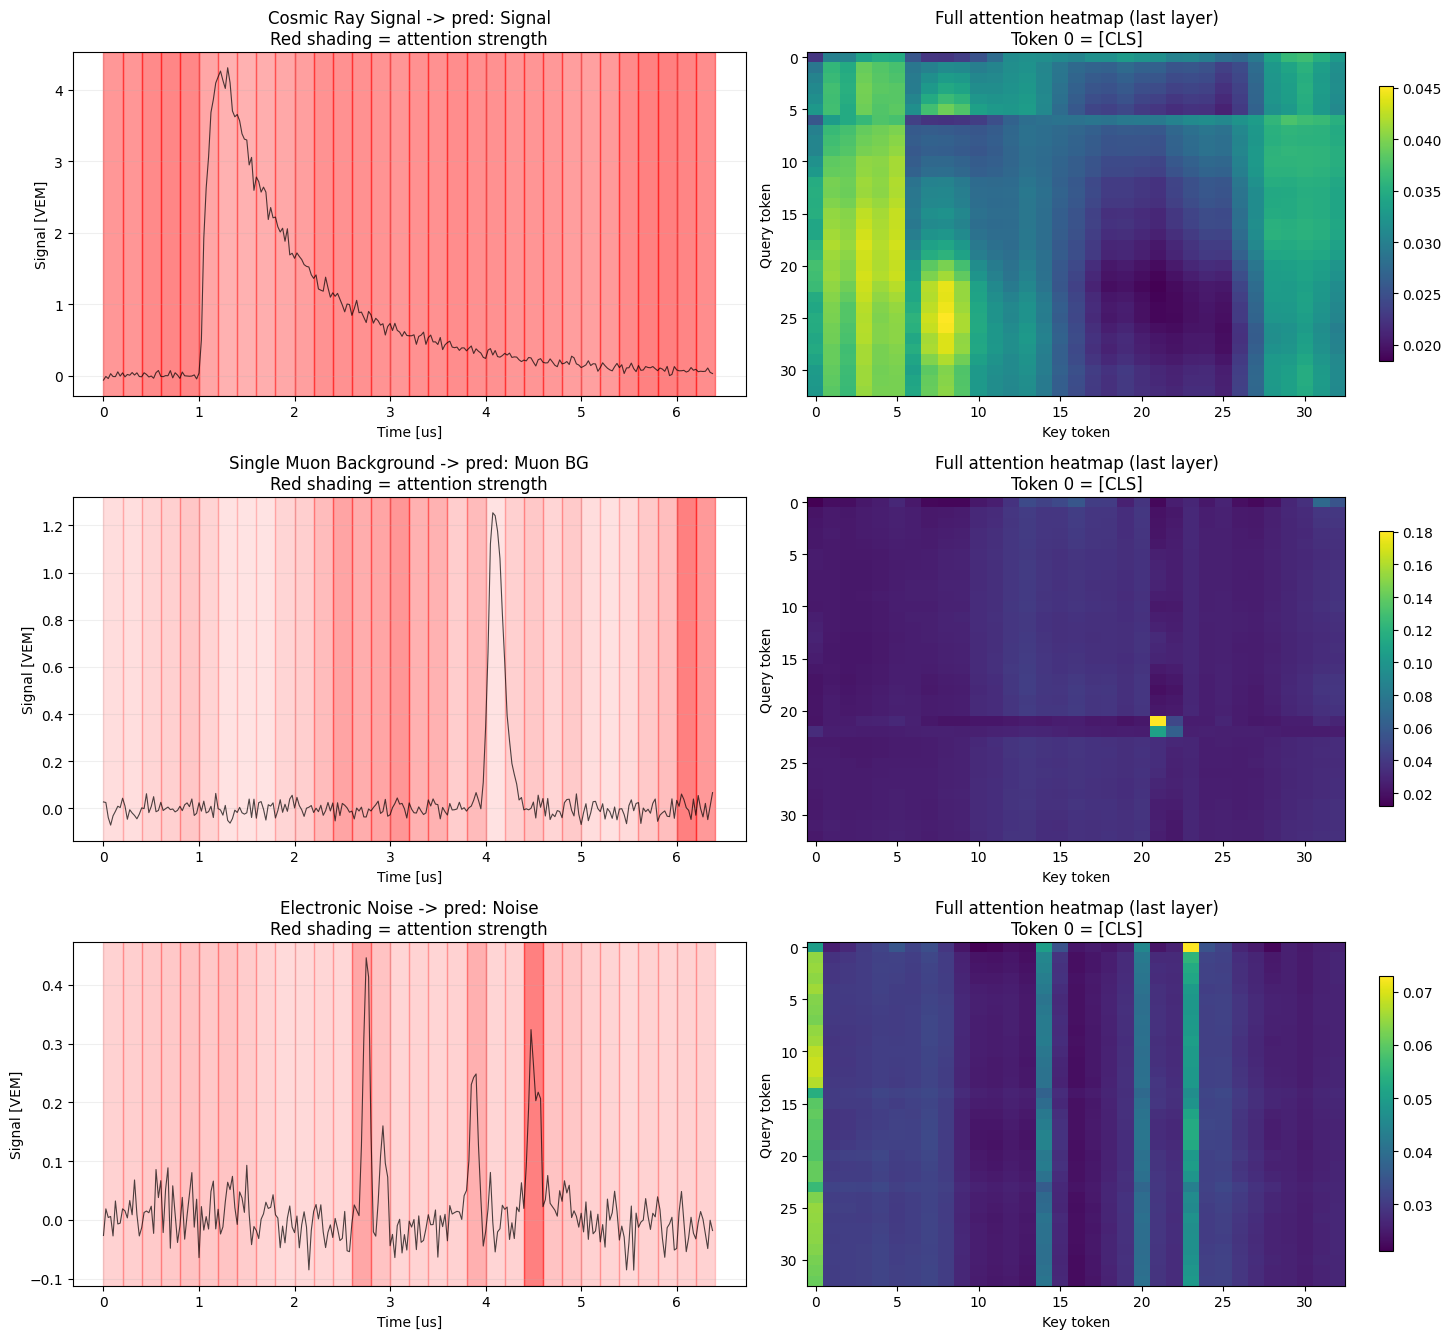

In [18]:
fig, axes = plt.subplots(NUM_CLASSES, 2, figsize=(15, 4.5 * NUM_CLASSES))
time_us = np.arange(WAVEFORM_LENGTH) * SAMPLING_DT * 1e6
patch_centers = np.array([(i + 0.5) * model.patch_size for i in range(model.n_patches)])
patch_time_us = patch_centers * SAMPLING_DT * 1e6

for cls in range(NUM_CLASSES):
    idx = next(i for i in range(len(val_ds)) if val_ds.labels[i] == cls)
    wf, label = val_ds[idx]
    wf_dev = wf.unsqueeze(0).to(DEVICE)

    logits, attn_list = extract_attention(model, wf_dev)
    pred = logits.argmax(1).item()

    # CLS token attention to each patch (last layer, row 0 = CLS)
    cls_attn = attn_list[-1][0, 0, 1:].cpu().numpy()  # skip CLS-to-CLS
    cls_attn /= cls_attn.max() + 1e-8

    # -- Left: waveform with attention overlay --
    ax = axes[cls, 0]
    ax.plot(time_us, wf.numpy(), linewidth=0.8, color="k", alpha=0.7)
    for i in range(len(cls_attn)):
        t_start = i * model.patch_size * SAMPLING_DT * 1e6
        t_end   = (i + 1) * model.patch_size * SAMPLING_DT * 1e6
        ax.axvspan(t_start, t_end, alpha=cls_attn[i] * 0.5, color="red")
    ax.set_xlabel("Time [us]")
    ax.set_ylabel("Signal [VEM]")
    ax.set_title(f"{CLASS_NAMES[cls]} -> pred: {CLASS_SHORT[pred]}\n"
                 "Red shading = attention strength")
    ax.grid(alpha=0.2)

    # -- Right: attention heatmap (all tokens) --
    ax = axes[cls, 1]
    attn_map = attn_list[-1][0].cpu().numpy()  # (n_patches+1, n_patches+1)
    im = ax.imshow(attn_map, cmap="viridis", aspect="auto")
    ax.set_xlabel("Key token"); ax.set_ylabel("Query token")
    ax.set_title(f"Full attention heatmap (last layer)\nToken 0 = [CLS]")
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

Wow! We can see exactly where the attention is focused.

How good is the classification, in the end? Let's look at the confusion matrix.

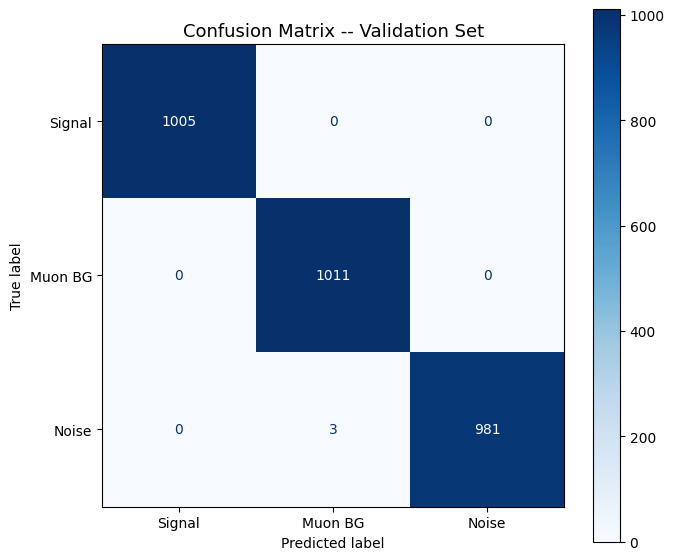


Classification Report:
              precision    recall  f1-score   support

      Signal       1.00      1.00      1.00      1005
     Muon BG       1.00      1.00      1.00      1011
       Noise       1.00      1.00      1.00       984

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for wf, labels in val_loader:
        logits = model(wf.to(DEVICE))
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_SHORT)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix -- Validation Set", fontsize=13)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_SHORT))

That confusion matrix is almost perfect.
You might think we overtrained, but the results on the test dataset are also very good.

The takeaway is that this dataset is very clean. A real experimental dataset might be more messy.

Just for fun, let's look at the (few) waveforms that were misclassified.

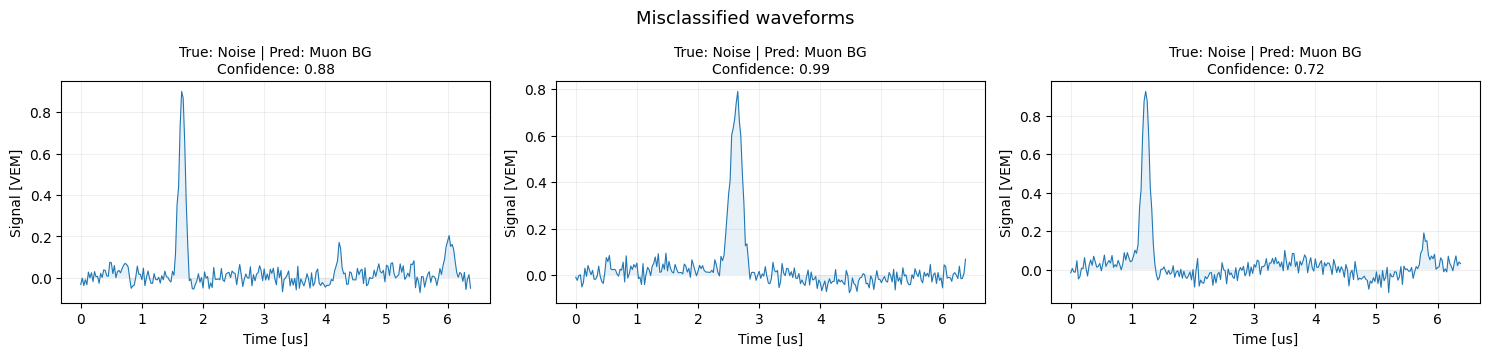

In [20]:
model.eval()
misclassified = []
with torch.no_grad():
    for i in range(len(val_ds)):
        wf, label = val_ds[i]
        logits = model(wf.unsqueeze(0).to(DEVICE))
        pred = logits.argmax(1).item()
        if pred != label:
            conf = F.softmax(logits, dim=1).max().item()
            misclassified.append((i, label, pred, conf))
        if len(misclassified) >= 6:
            break

if misclassified:
    n_show = min(6, len(misclassified))
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()
    for j in range(n_show):
        idx, true_cls, pred_cls, conf = misclassified[j]
        wf = val_ds.waveforms[idx]
        ax = axes[j]
        ax.plot(time_us, wf, linewidth=0.8)
        ax.fill_between(time_us, 0, wf, alpha=0.1)
        ax.set_title(f"True: {CLASS_SHORT[true_cls]} | Pred: {CLASS_SHORT[pred_cls]}\n"
                     f"Confidence: {conf:.2f}", fontsize=10)
        ax.set_xlabel("Time [us]"); ax.set_ylabel("Signal [VEM]")
        ax.grid(alpha=0.2)
    for j in range(n_show, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle("Misclassified waveforms", fontsize=13)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples found in the first scan!")

Can you understand how the transformer algorithm got confused between Muon BG and Noise?

## Last comments

- The attention-based transformer is better than RNN for this application because it can focus directly on specific features wherever they are instead of using a long pipeline to connect features.
- We added positional encoding so that we could take "nearness" into account. This allows the model to learn rise time, spikes, and decay times. (Compare to the particle jet classifier, which did not use positional encoding.)
- The tokenization by patches transforms the pseudo-continuous waveform into discrete chunks. This is tunable for the specific situation at hand.

# Recurrent Neural Network model of projectile motion with air resistance

Projectile motion is a natural candidate for RNN because of the time-series nature of the system evolution.

This is a nonlinear ODE with no simple analytical solution.

We will train an RNN to predict future positions given past trajectory points.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.integrate import odeint

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')

Using device: cuda


## Generate synthetic dataset

First, we'll simulate projectile motion with air resistance using numerical integration.

In [22]:
class ProjectileSimulator:
    """
    Simulate projectile motion with quadratic air resistance.
    """
    def __init__(self, g=9.81, b=0.1, m=1.0):
        """
        Args:
            g: Gravitational acceleration (m/s²)
            b: Drag coefficient (kg/m)
            m: Mass (kg)
        """
        self.g = g
        self.b = b
        self.m = m

    def derivatives(self, state, t):
        """
        Compute derivatives for ODE integration.

        Args:
            state: [x, y, vx, vy]
            t: time

        Returns:
            [vx, vy, ax, ay]
        """
        x, y, vx, vy = state

        # Speed
        v = np.sqrt(vx**2 + vy**2)

        # Drag force (quadratic in velocity)
        drag_x = -(self.b / self.m) * vx * v
        drag_y = -(self.b / self.m) * vy * v

        # Accelerations
        ax = drag_x
        ay = -self.g + drag_y

        return [vx, vy, ax, ay]

    def simulate(self, x0, y0, vx0, vy0, t_max=5.0, dt=0.05):
        """
        Simulate projectile trajectory.

        Args:
            x0, y0: Initial position
            vx0, vy0: Initial velocity
            t_max: Maximum simulation time
            dt: Time step

        Returns:
            t, x, y, vx, vy: Time and state arrays
        """
        # Initial state
        state0 = [x0, y0, vx0, vy0]

        # Time array
        t = np.arange(0, t_max, dt)

        # Integrate
        solution = odeint(self.derivatives, state0, t)

        x = solution[:, 0]
        y = solution[:, 1]
        vx = solution[:, 2]
        vy = solution[:, 3]

        # Stop when projectile hits ground
        idx_ground = np.where(y < 0)[0]
        if len(idx_ground) > 0:
            idx = idx_ground[0]
            t = t[:idx]
            x = x[:idx]
            y = y[:idx]
            vx = vx[:idx]
            vy = vy[:idx]

        return t, x, y, vx, vy

# Create simulator
sim = ProjectileSimulator(g=9.81, b=0.1, m=1.0)

# Generate one example trajectory
t, x, y, vx, vy = sim.simulate(x0=0, y0=0, vx0=20, vy0=20, t_max=5.0, dt=0.05)

print(f"Simulated trajectory:")
print(f"  Duration: {t[-1]:.2f} seconds")
print(f"  Max height: {y.max():.2f} m")
print(f"  Range: {x[-1]:.2f} m")
print(f"  Number of points: {len(t)}")

Simulated trajectory:
  Duration: 2.20 seconds
  Max height: 6.41 m
  Range: 14.91 m
  Number of points: 45


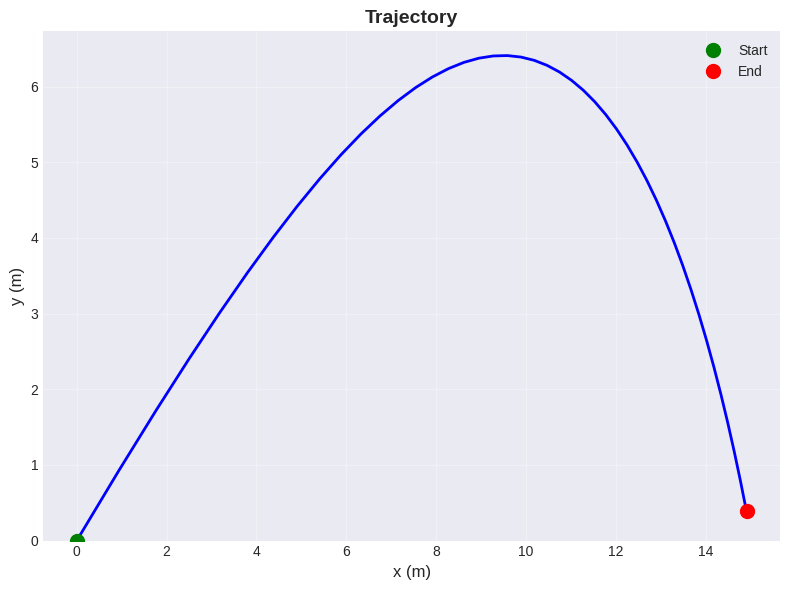

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Trajectory
ax.plot(x, y, 'b-', linewidth=2)
ax.plot(x[0], y[0], 'go', markersize=10, label='Start')
ax.plot(x[-1], y[-1], 'ro', markersize=10, label='End')
ax.set_xlabel('x (m)', fontsize=12)
ax.set_ylabel('y (m)', fontsize=12)
ax.set_title('Trajectory', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

In [27]:
def generate_dataset(sim, n_trajectories=200, dt=0.05):
    """
    Generate dataset of projectile trajectories.
    """
    trajectories = []

    for _ in range(n_trajectories):
        # Random initial velocities
        vx0 = np.random.uniform(10, 30)
        vy0 = np.random.uniform(10, 30)

        # Simulate
        t, x, y, vx, vy = sim.simulate(
            x0=0, y0=0, vx0=vx0, vy0=vy0, t_max=10.0, dt=dt
        )

        # Store as (x, y) pairs
        traj = np.column_stack([x, y])
        trajectories.append(traj)

    return trajectories

print("Generating training data...")
train_trajectories = generate_dataset(sim, n_trajectories=200)
print(f"Generated {len(train_trajectories)} training trajectories")

print("\nGenerating validation data...")
val_trajectories = generate_dataset(sim, n_trajectories=50)
print(f"Generated {len(val_trajectories)} validation trajectories")

print("\nGenerating test data...")
test_trajectories = generate_dataset(sim, n_trajectories=50)
print(f"Generated {len(test_trajectories)} test trajectories")

# Show statistics
lengths = [len(traj) for traj in train_trajectories]
print(f"\nTrajectory lengths: min={min(lengths)}, max={max(lengths)}, mean={np.mean(lengths):.1f}")

Generating training data...
Generated 200 training trajectories

Generating validation data...
Generated 50 validation trajectories

Generating test data...
Generated 50 test trajectories

Trajectory lengths: min=27, max=60, mean=45.8


### Create PyTorch Dataset

We'll use a sliding window approach:
- Input: Past 5 positions → `[(x₁,y₁), (x₂,y₂), ..., (x₅,y₅)]`
- Output: Next position → `(x₆,y₆)`

In [28]:
class TrajectoryDataset(Dataset):
    """
    Dataset for trajectory prediction.
    Uses sliding window to create sequences.
    """
    def __init__(self, trajectories, seq_length=5):
        """
        Args:
            trajectories: List of trajectory arrays
            seq_length: Number of past points to use as input
        """
        self.seq_length = seq_length
        self.sequences = []
        self.targets = []

        # Create sequences from all trajectories
        for traj in trajectories:
            # Need at least seq_length + 1 points
            if len(traj) < seq_length + 1:
                continue

            # Sliding window
            for i in range(len(traj) - seq_length):
                seq = traj[i:i+seq_length]  # Past positions
                target = traj[i+seq_length]  # Next position

                self.sequences.append(seq)
                self.targets.append(target)

        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)

        # Normalize data (helps training)
        self.x_mean = self.sequences[:, :, 0].mean()
        self.x_std = self.sequences[:, :, 0].std()
        self.y_mean = self.sequences[:, :, 1].mean()
        self.y_std = self.sequences[:, :, 1].std()

        self.sequences[:, :, 0] = (self.sequences[:, :, 0] - self.x_mean) / self.x_std
        self.sequences[:, :, 1] = (self.sequences[:, :, 1] - self.y_mean) / self.y_std

        self.targets[:, 0] = (self.targets[:, 0] - self.x_mean) / self.x_std
        self.targets[:, 1] = (self.targets[:, 1] - self.y_mean) / self.y_std

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            'sequence': torch.FloatTensor(self.sequences[idx]),
            'target': torch.FloatTensor(self.targets[idx])
        }

    def denormalize(self, normalized_pos):
        """Convert normalized positions back to original scale."""
        denorm = normalized_pos.copy()
        denorm[..., 0] = denorm[..., 0] * self.x_std + self.x_mean
        denorm[..., 1] = denorm[..., 1] * self.y_std + self.y_mean
        return denorm

# Create datasets
seq_length = 5
train_dataset = TrajectoryDataset(train_trajectories, seq_length=seq_length)
val_dataset = TrajectoryDataset(val_trajectories, seq_length=seq_length)
test_dataset = TrajectoryDataset(test_trajectories, seq_length=seq_length)

print(f"Dataset sizes:")
print(f"  Training: {len(train_dataset)} sequences")
print(f"  Validation: {len(val_dataset)} sequences")
print(f"  Test: {len(test_dataset)} sequences")

print(f"\nSequence shape: {train_dataset[0]['sequence'].shape}")
print(f"Target shape: {train_dataset[0]['target'].shape}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Dataset sizes:
  Training: 8161 sequences
  Validation: 1953 sequences
  Test: 2040 sequences

Sequence shape: torch.Size([5, 2])
Target shape: torch.Size([2])


In [32]:
class ProjectileRNN(nn.Module):
    """
    RNN for learning projectile motion.
    """
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, output_size=2):
        super(ProjectileRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_length, 2)

        # RNN forward
        # out shape: (batch, seq_length, hidden_size)
        out, _ = self.rnn(x)

        # Use last time step output
        out = out[:, -1, :]  # Shape: (batch, hidden_size)

        # Predict next position
        out = self.fc(out)  # Shape: (batch, 2)

        return out

# Create model
model = ProjectileRNN(input_size=2, hidden_size=64, num_layers=3, output_size=2)
model = model.to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

ProjectileRNN(
  (rnn): RNN(2, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 21,122


In [33]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
val_losses = []

print(f"Training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        x = batch['sequence'].to(device)
        y = batch['target'].to(device)

        # Forward
        outputs = model(x)
        loss = criterion(outputs, y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            x = batch['sequence'].to(device)
            y = batch['target'].to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\nTraining complete!")

Training for 50 epochs...

Epoch [10/50], Train Loss: 0.000205, Val Loss: 0.000378
Epoch [20/50], Train Loss: 0.000143, Val Loss: 0.000052
Epoch [30/50], Train Loss: 0.000073, Val Loss: 0.000236
Epoch [40/50], Train Loss: 0.000145, Val Loss: 0.000090
Epoch [50/50], Train Loss: 0.000015, Val Loss: 0.000018

Training complete!


Ground truth length: 56
Predicted length: 56


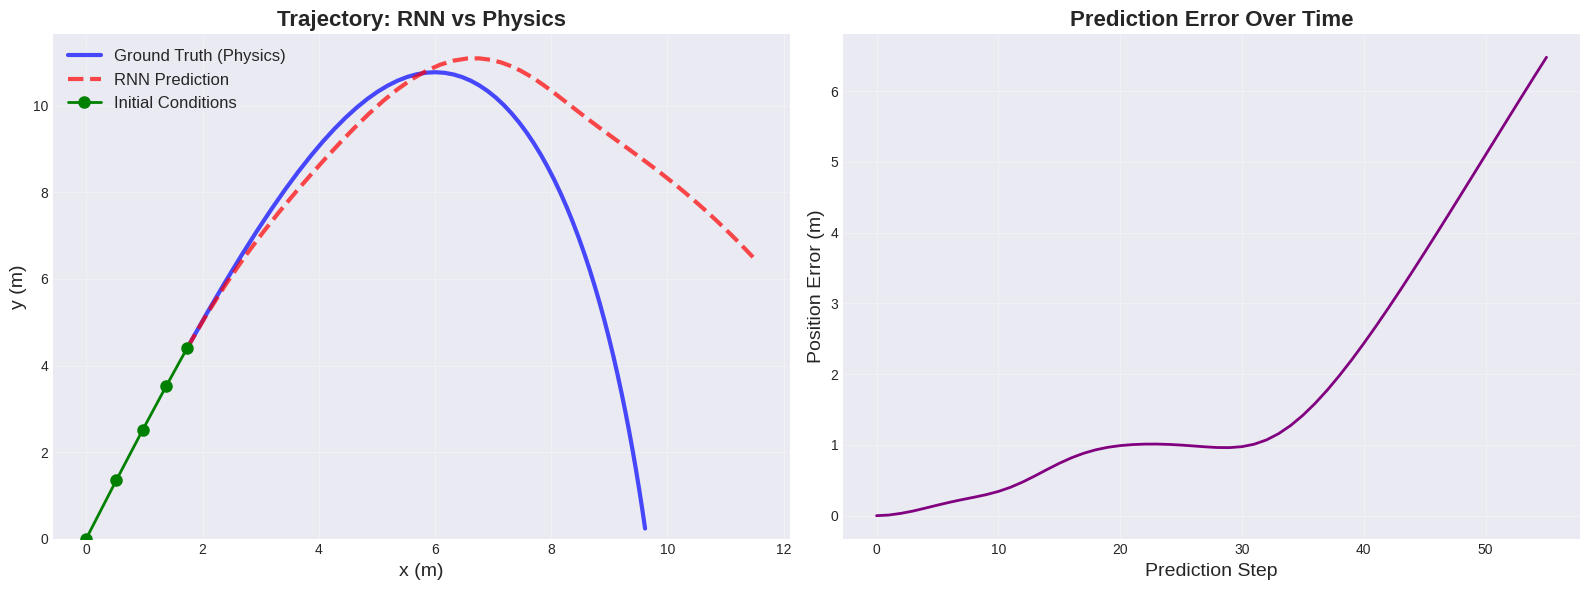


Final prediction error: 6.481 m
Mean prediction error: 1.844 m
Max prediction error: 6.481 m


In [36]:
def predict_trajectory(model, initial_positions, n_steps, dataset):
    """
    Autoregressive prediction: use model's own predictions as input.

    Args:
        model: Trained RNN
        initial_positions: Starting positions (seq_length, 2)
        n_steps: Number of steps to predict
        dataset: For normalization

    Returns:
        predicted_trajectory: (n_steps, 2)
    """
    model.eval()

    # Normalize initial positions
    positions = initial_positions.copy()
    positions[:, 0] = (positions[:, 0] - dataset.x_mean) / dataset.x_std
    positions[:, 1] = (positions[:, 1] - dataset.y_mean) / dataset.y_std

    # Store predictions
    predicted = [positions[-1]]  # Start with last initial position

    with torch.no_grad():
        current_seq = torch.FloatTensor(positions).unsqueeze(0).to(device)  # (1, seq_length, 2)

        for _ in range(n_steps):
            # Predict next position
            next_pos = model(current_seq)
            next_pos_np = next_pos.cpu().numpy()[0]

            # Store
            predicted.append(next_pos_np)

            # Update sequence (shift left and append new prediction)
            current_seq = torch.cat([current_seq[:, 1:, :], next_pos.unsqueeze(1)], dim=1)

    predicted = np.array(predicted)

    # Denormalize
    predicted_denorm = dataset.denormalize(predicted)

    return predicted_denorm

# Test on a trajectory
test_traj = test_trajectories[0]

# Use first 5 points as input, predict the rest
initial = test_traj[:seq_length]
ground_truth = test_traj[seq_length-1:]  # Include last initial point

# Predict
predicted = predict_trajectory(model, initial, len(ground_truth)-1, train_dataset)

print(f"Ground truth length: {len(ground_truth)}")
print(f"Predicted length: {len(predicted)}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Trajectory comparison
axes[0].plot(ground_truth[:, 0], ground_truth[:, 1], 'b-',
            linewidth=3, label='Ground Truth (Physics)', alpha=0.7)
axes[0].plot(predicted[:, 0], predicted[:, 1], 'r--',
            linewidth=3, label='RNN Prediction', alpha=0.7)
axes[0].plot(initial[:, 0], initial[:, 1], 'go-',
            linewidth=2, markersize=8, label='Initial Conditions')
axes[0].set_xlabel('x (m)', fontsize=14)
axes[0].set_ylabel('y (m)', fontsize=14)
axes[0].set_title('Trajectory: RNN vs Physics', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(bottom=0)

# Error over time
min_len = min(len(ground_truth), len(predicted))
errors = np.sqrt(np.sum((ground_truth[:min_len] - predicted[:min_len])**2, axis=1))
time_steps = np.arange(min_len)

axes[1].plot(time_steps, errors, 'purple', linewidth=2)
axes[1].set_xlabel('Prediction Step', fontsize=14)
axes[1].set_ylabel('Position Error (m)', fontsize=14)
axes[1].set_title('Prediction Error Over Time', fontsize=16, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal prediction error: {errors[-1]:.3f} m")
print(f"Mean prediction error: {errors.mean():.3f} m")
print(f"Max prediction error: {errors.max():.3f} m")